In [1]:
import casadi
from casadi import *
import numpy
import math

In [2]:
def MX_skew(x):
    # Obtain skew-symmetric matrix from vector MX

    n = MX.size(x)[0]
    if n == 3:
        X = vertcat(   horzcat(0,      -x[(2)],    x[(1)]), horzcat(x[(2)],    0,      -x[(0)]),  horzcat(-x[(1)],    x[(0)],    0)     );
    elif n == 1:
        X = vertcat(   horzcat(0,      -x[(0)]), horzcat(x[(0)],    0)    );
    else:
        error('SKEW function not implemented for input dimensions other than 1 or 3 (i.e., so(2) and so(3)).');
        
        
    return X

In [3]:
def desfasamento_obtencao(x01,x02, pos_i, C):
    
    tau = math.atan((x01[1]-x02[1])/(x01[0]-x02[0]))
    
    aux1 = norm_2(mtimes(C,x01) - 2*vertcat(cos(tau), sin(tau)) - pos_i)
    aux2 = norm_2(mtimes(C,x02) - 2*vertcat(cos(tau+pi), sin(tau+pi)) - pos_i)
    
    aux3 = norm_2(mtimes(C,x01) - 2*vertcat(cos(tau+pi), sin(tau+pi)) - pos_i)
    aux4 = norm_2(mtimes(C,x02) - 2*vertcat(cos(tau), sin(tau)) - pos_i)
    
    if aux1 + aux2 < aux3 + aux4:
        return tau
    else :
        return tau+pi

In [4]:
b = 0.22 #m 
vmax = 1 # m/s
amax = 3 # m/s^2
alfamax = amax * (2/b) #rad/s


Th = 1.2 # horizon time 
Nh = 6 # number of control intervals
dt = Th/Nh # length of a control interval
nx = 3 # number of states
nu = 2 # number of inputs
ny = 2 # number of outputs




from casadi import *

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(nx,Nh+1) # state trajectory
state_x   = X[0,:] # position x
state_y = X[1,:] # position y
state_theta   = X[2,:] # orientation

U = opti.variable(nu,Nh)   # control trajectory (linear and angular speed)
input_linear_vel = U[0,:]
input_angular_vel = U[1,:]

Vl = opti.variable(1,Nh) 
Vr = opti.variable(1,Nh) 

Ref = opti.variable(ny,Nh+1)
ref_x = Ref[0,:]
ref_y = Ref[1,:]


OldU = opti.variable(nu,1)

PosVehicle = opti.variable(2,Nh+1)
Pos_x_Vehicle = PosVehicle[0,:]
Pos_y_Vehicle = PosVehicle[1,:]


X0_parameter = opti.parameter(nx,1)
OldU_parameter = opti.parameter(nu,1)
Ref_x_parameter = opti.parameter(1,Nh+1)
Ref_y_parameter = opti.parameter(1,Nh+1)
Pos_x_Vehicle_parameter = opti.parameter(1,Nh+1)
Pos_y_Vehicle_parameter = opti.parameter(1,Nh+1)

# ---- objective          ---------

Q = 7
R = 1


C = DM([[1, 0, 0],[0, 1, 0]])

Y = mtimes(C,X) 
difyr = Y - Ref

# ---- dynamic constraints --------
f = lambda x,u: vertcat(u[0]*cos(x[2]), u[0]*sin(x[2]), u[1]) # dx/dt = f(x,u)
objective = 0
for k in range(Nh): # loop over control intervals   
    
   relativePos = Y[:,k] - PosVehicle[:,k]

   crossPro = MX_skew(vertcat(f(X[:,k], U[:,k])[0:2],0))*vertcat(relativePos,0)

   objective = objective + sumsqr(U[:,k])*R + sumsqr(difyr[:,k])*Q + crossPro[3]
    
   # Runge-Kutta 4 integration
   k1 = f(X[:,k],         U[:,k])
   k2 = f(X[:,k]+dt/2*k1, U[:,k])
   k3 = f(X[:,k]+dt/2*k2, U[:,k])
   k4 = f(X[:,k]+dt*k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # close the gaps

objective = objective + sumsqr(difyr[:,k+1])*Q
opti.minimize(objective)

# ---- constraints -----------

opti.subject_to(opti.bounded(0,input_linear_vel,vmax)) 

opti.subject_to(state_x[0]==X0_parameter[0])   
opti.subject_to(state_y[0]==X0_parameter[1]) 
opti.subject_to(state_theta[0]==X0_parameter[2])  

opti.subject_to(ref_x[:]==Ref_x_parameter) 
opti.subject_to(ref_y[:]==Ref_y_parameter) 

opti.subject_to(OldU[0]==OldU_parameter[0])  
opti.subject_to(OldU[1]==OldU_parameter[1])

opti.subject_to(Pos_x_Vehicle[:]==Pos_x_Vehicle_parameter)
opti.subject_to(Pos_y_Vehicle[:]==Pos_y_Vehicle_parameter)

Us = horzcat(OldU,U)
UsDiff = casadi.diff(Us,1,1)
opti.subject_to(opti.bounded(-amax*dt,UsDiff[0,:],amax*dt)) 
opti.subject_to(opti.bounded(-alfamax*dt,UsDiff[1,:],alfamax*dt)) 
opti.subject_to(input_linear_vel == 0.5*(Vl + Vr))
opti.subject_to(input_linear_vel == (Vr - Vl)/b)


# ---- initial values for solver ---
opti.set_initial(input_linear_vel, 1)
opti.set_initial(input_angular_vel, 1)

# ---- make the solver silent ------ to see the time of computation, iterations... remove or change to True
opts = {}
another_opts = {}
opts['verbose'] = False
opts['print_time'] = False
another_opts['print_level'] = 0

# ---- solve NLP  ------
opti.opts = {"ipopt.tol":1e-10, "expand":True}
opti.solver("ipopt", opts,another_opts) # set numerical backend

controller = opti.to_function("controller", [OldU_parameter, X0_parameter, Ref_x_parameter, Ref_y_parameter, Pos_x_Vehicle_parameter, Pos_y_Vehicle_parameter], [U[:,0]], ["u_prev", "x0", "ref_x", "ref_y", "pos_x_vehicle", "pos_y_vehicle"], ["u_opt"]) #para defenir o estado inicial tem-se de enviar por meio de parametros a não ser que fosse todo o X, o U como é output não dá erro


In [5]:
#Simulation

Ts = 0.2
T = 80
numberIterations = round(T/Ts)

time_beyond_mpc= dt*Nh*0.5#s 
iterations_beyond_mpc = round(time_beyond_mpc/dt)



car_speed_x = 0.08 
car_speed_y = 0.08 

car_x0 = 3
car_y0 = 3


carPath_x = np.array(range(0, Nh + numberIterations + iterations_beyond_mpc ))*dt*car_speed_x + car_x0 
carPath_y = np.array(range(0, Nh + numberIterations + iterations_beyond_mpc ))*dt*car_speed_y + car_y0

robot1_x0 = 0
robot1_y0 = 0
robot1_theta0 = 0
robot1_states = vertcat(robot1_x0, robot1_y0, robot1_theta0)

robot2_x0 = 1
robot2_y0 = 1
robot2_theta0 = 0
robot2_states = vertcat(robot2_x0, robot2_y0, robot2_theta0)

uhist1 = vertcat(0,0)
uhist2 = vertcat(0,0)


tau = desfasamento_obtencao(robot1_states, robot2_states, vertcat(carPath_x[0], carPath_y[0]), C) 


j = -1

for i in range(numberIterations):
        
        
        if i%round(dt/Ts) == 0:
            j+=1

            reference1_xj = carPath_x[j] + 2*cos(j*dt*2*pi/40 + tau)
            reference1_yj = carPath_y[j] + 2*sin(j*dt*2*pi/40 + tau)
            reference1_j = vertcat(reference1_xj, reference1_yj) 


            if norm_2(mtimes(C, robot1_states[:,j])- reference1_j) > 3: 

                k1 = j + iterations_beyond_mpc


            else:
                k1 = j


            reference2_xj = carPath_x[j] + 2*cos(j*dt*2*pi/40 + tau + pi)
            reference2_yj = carPath_y[j] + 2*sin(j*dt*2*pi/40 + tau + pi)
            reference2_j = vertcat(reference2_xj, reference2_yj) 


            if norm_2(mtimes(C, robot2_states[:,j])- reference2_j) > 3: 

                k2 = j + iterations_beyond_mpc

            else:
                k2 = j


            aux1 = np.array(range(k1,k1 + Nh +1)) 
            aux2 = np.array(range(k2,k2 + Nh +1)) 



            reference1_x = carPath_x[k1:k1+Nh+1] + 2*cos(aux1*dt*2*pi/40 + tau) 
            reference2_x = carPath_x[k2:k2+Nh+1] + 2*cos(aux2*dt*2*pi/40 + tau + pi)

            reference1_y = carPath_y[k1:k1+Nh+1] + 2*sin(aux1*dt*2*pi/40 + tau)
            reference2_y = carPath_y[k2:k2+Nh+1] + 2*sin(aux2*dt*2*pi/40 + tau + pi)

            u_mpc=controller(uhist1[:,j], robot1_states[:,j], reference1_x, reference1_y, carPath_x[k1:k1+Nh+1], carPath_y[k1:k1+Nh+1]) 
            uhist1 = horzcat(uhist1,u_mpc)




            xnext1 = f(robot1_states[:,j],u_mpc)*dt + robot1_states[:,j]
            robot1_states = horzcat(robot1_states, xnext1)


            u_mpc=controller(uhist2[:,j], robot2_states[:,j], reference2_x, reference2_y, carPath_x[k2:k2+Nh+1], carPath_y[k2:k2+Nh+1]) 
            uhist2 = horzcat(uhist2,u_mpc)

            xnext2 = f(robot2_states[:,j],u_mpc)*dt + robot2_states[:,j]
            robot2_states = horzcat(robot2_states, xnext2)
        
    







******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



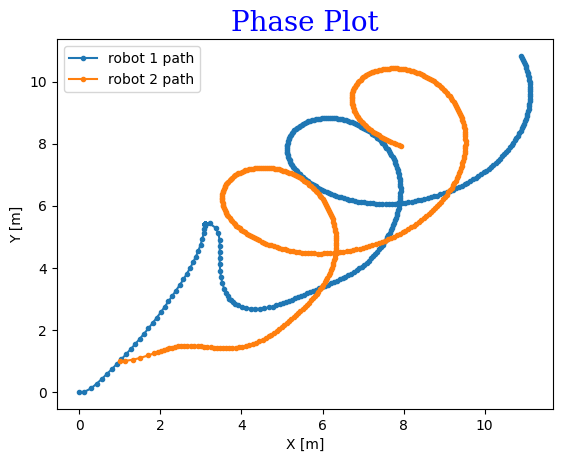

In [6]:
# ---- post-processing        ------
from pylab import plot, step, figure, legend, show, spy
import matplotlib.pyplot as plt

t = np.array(range(len(np.array(robot1_states[0,:])[0])))*dt


figure()
plt.plot(np.array(robot1_states[0,:])[0],np.array(robot1_states[1,:])[0], marker = '.', label="robot 1 path")
plt.plot(np.array(robot2_states[0,:])[0],np.array(robot2_states[1,:])[0], marker = '.', label="robot 2 path")
legend(loc="upper left")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Phase Plot", fontdict = {'family':'serif','color':'blue','size':20})


show()


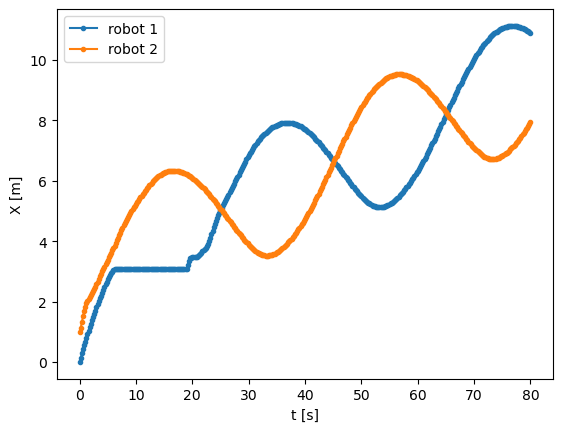

In [14]:
figure()
plt.plot(t,np.array(robot1_states[0,:])[0],label="robot 1", marker = '.')
plt.plot(t,np.array(robot2_states[0,:])[0],label="robot 2", marker = '.')
legend(loc="upper left")
plt.xlabel("t [s]")
plt.ylabel("X [m]")
show()


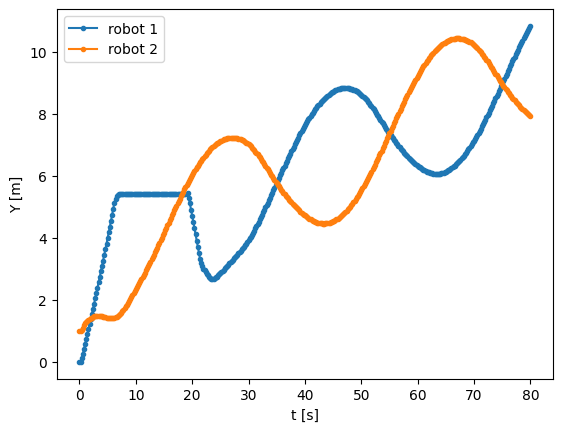

In [7]:

figure()
plot(t,np.array(robot1_states[1,:])[0],label="robot 1", marker = '.')
plot(t,np.array(robot2_states[1,:])[0],label="robot 2", marker = '.')
legend(loc="upper left")
plt.xlabel("t [s]")
plt.ylabel("Y [m]")
show()



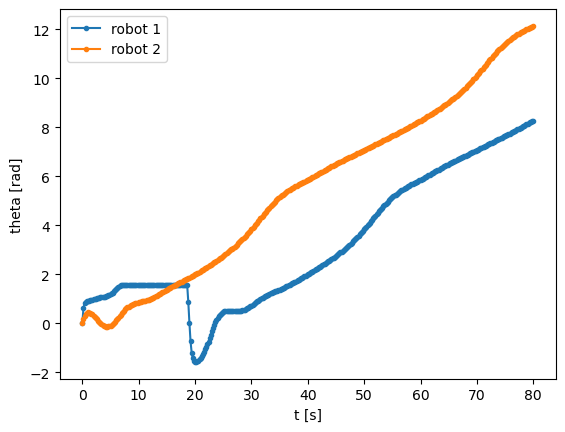

In [16]:
figure()
plot(t,np.array(robot1_states[2,:])[0],label="robot 1", marker = '.')
plot(t,np.array(robot2_states[2,:])[0],label="robot 2", marker = '.')
legend(loc="upper left")
plt.xlabel("t [s]")
plt.ylabel("theta [rad]")
show()



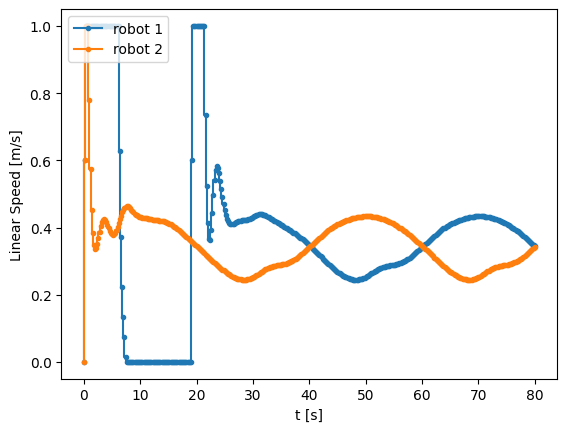

In [8]:
figure()
step(t,np.array(uhist1[0,:])[0],label="robot 1", marker = '.')
step(t,np.array(uhist2[0,:])[0],label="robot 2", marker = '.')
legend(loc="upper left")
plt.xlabel("t [s]")
plt.ylabel("Linear Speed [m/s]")
show()



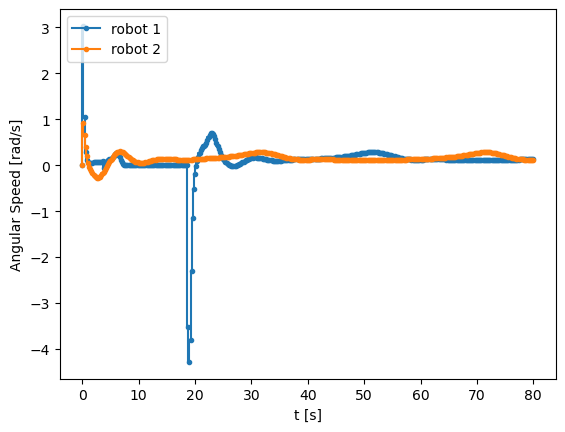

In [18]:
figure()
step(t,np.array(uhist1[1,:])[0],label="robot 1", marker = '.')
step(t,np.array(uhist2[1,:])[0],label="robot 2", marker = '.')
legend(loc="upper left")
plt.xlabel("t [s]")
plt.ylabel("Angular Speed [rad/s]")
show()